In [1]:
pip install pandas matplotlib seaborn numpy scipy statsmodels scikit-learn xgboost pydantic fastapi uvicorn

Note: you may need to restart the kernel to use updated packages.


In [79]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso, LassoCV, lasso_path, LinearRegression 
from sklearn.metrics import root_mean_squared_error, r2_score
import numpy as np
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

In [5]:
# import data
df = pd.read_csv('clean0_project_1.csv')

In [6]:
# glimpse of data
df.head()

,symboling,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,length,...,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,...,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,13495
1,3,alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,...,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,16500
2,1,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,171.2,...,152,mpfi,2.68,3.47,9.0,154.0,5000.0,19,26,16500
3,2,audi,gas,std,four,sedan,fwd,front,99.8,176.6,...,109,mpfi,3.19,3.40,10.0,102.0,5500.0,24,30,13950
4,2,audi,gas,std,four,sedan,4wd,front,99.4,176.6,...,136,mpfi,3.19,3.40,8.0,115.0,5500.0,18,22,17450


In [7]:
# some info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201 entries, 0 to 200
Data columns (total 25 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   symboling          201 non-null    int64  
 1   make               201 non-null    object 
 2   fuel-type          201 non-null    object 
 3   aspiration         201 non-null    object 
 4   num-of-doors       201 non-null    object 
 5   body-style         201 non-null    object 
 6   drive-wheels       201 non-null    object 
 7   engine-location    201 non-null    object 
 8   wheel-base         201 non-null    float64
 9   length             201 non-null    float64
 10  width              201 non-null    float64
 11  height             201 non-null    float64
 12  curb-weight        201 non-null    int64  
 13  engine-type        201 non-null    object 
 14  num-of-cylinders   201 non-null    object 
 15  engine-size        201 non-null    int64  
 16  fuel-system        201 non

In [8]:
# Model Development Life Cycle 1 - Understanding the intent
# We have a dataset of attributes of cars. By looking at the attributes, we need to prdict the car price.

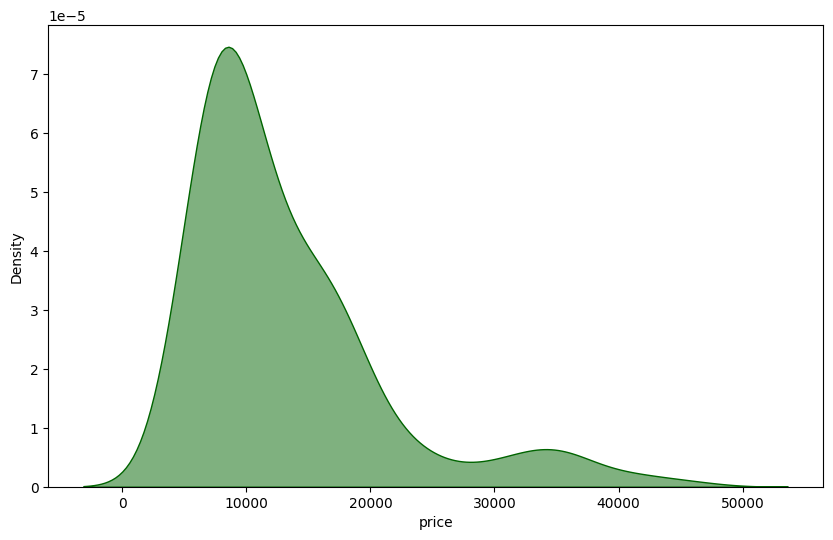

In [9]:
# Model Development Life Cycle 2 - Exploratory Data Analyses
# price distribution
plt.figure(figsize=(10, 6))
sns.kdeplot(df['price'], color='darkgreen', linewidth=1, fill=True, alpha=0.5)
plt.show()

In [7]:
# symboling is of no use and hence we will eliminate it.

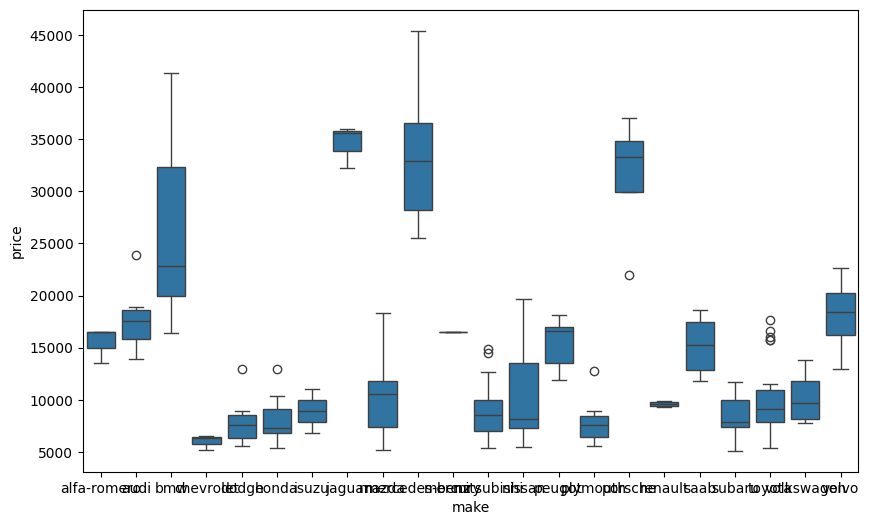

In [10]:
# boxplot to visually see if there is a significant difference of make on price
plt.figure(figsize=(10, 6))
sns.boxplot(x='make', y='price', data=df)
plt.show()

In [11]:
# there are too many classes in the make variable, and we need to group the ones with frequency as other
df['make'].value_counts()

make
toyota           32
nissan           18
mazda            17
mitsubishi       13
honda            13
subaru           12
volkswagen       12
volvo            11
peugot           11
dodge             9
mercedes-benz     8
bmw               8
plymouth          7
audi              6
saab              6
porsche           4
chevrolet         3
alfa-romero       3
jaguar            3
isuzu             2
renault           2
mercury           1
Name: count, dtype: int64

In [12]:
# classify low frequency classes into other
def classify(row):
    if row['make'] in ['toyota', 'nissan', 'mazda']:
        return row['make']
    else:
        return 'Other'
df['make'] = df.apply(classify, axis=1)

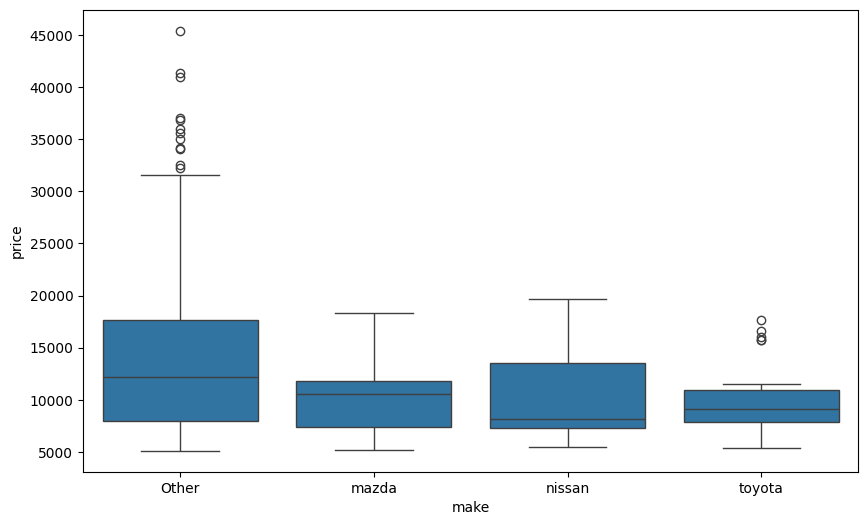

In [13]:
# replot to see 
plt.figure(figsize=(10, 6))
sns.boxplot(x='make', y='price', data=df)
plt.show()

In [14]:
# Is there an association between make and price
f_statistic, p_value = stats.f_oneway(df[df['make'] == 'toyota']['price'], 
                                      df[df['make'] == 'nissan']['price'],
                                      df[df['make'] == 'mazda']['price'],
                                      df[df['make'] == 'Other']['price']
                                     )
print("F_statistic : {} | p_value: {}".format(f_statistic, p_value))

F_statistic : 5.053103139374371 | p_value: 0.0021505142666811117


In [15]:
# post hoc analysis
tukey_results = pairwise_tukeyhsd(endog=df['price'], groups=df['make'], alpha=0.05)

print("\nPost-Hoc Test (Tukey's HSD):")
print(tukey_results)


Post-Hoc Test (Tukey's HSD):
    Multiple Comparison of Means - Tukey HSD, FWER=0.05    
group1 group2  meandiff  p-adj    lower      upper   reject
-----------------------------------------------------------
 Other  mazda -4046.4162 0.1781 -9193.7888 1100.9565  False
 Other nissan -4283.6318 0.1237 -9302.5156  735.2519  False
 Other toyota  -4813.486 0.0095 -8747.1807 -879.7913   True
 mazda nissan  -237.2157 0.9997 -6998.7819 6524.3505  False
 mazda toyota  -767.0699 0.9874 -6767.3646 5233.2249  False
nissan toyota  -529.8542 0.9955 -6420.2944 5360.5861  False
-----------------------------------------------------------


In [16]:
# seems like it is only toyota vs the rest

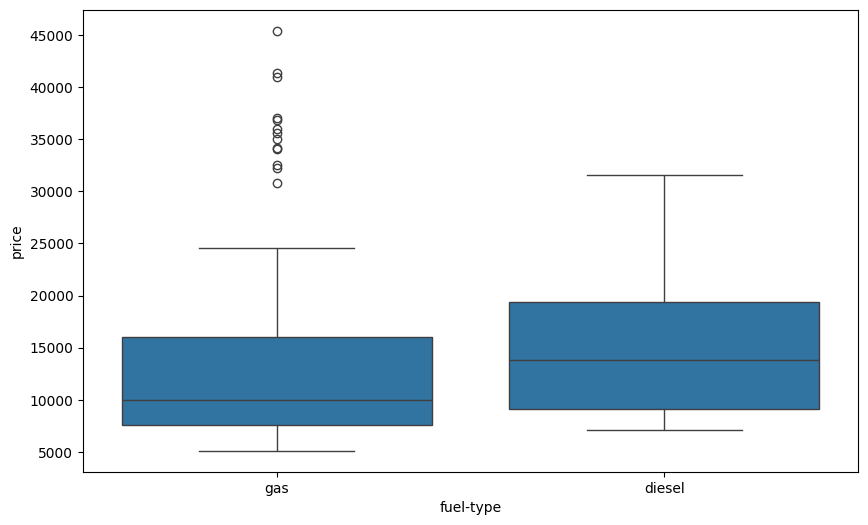

In [17]:
# boxplot to visually see if there is a significant difference on fuel type on price
plt.figure(figsize=(10, 6))
sns.boxplot(x='fuel-type', y='price', data=df)
plt.show()

In [18]:
# Is there an association between fuel-type and price
f_statistic, p_value = stats.f_oneway(df[df['fuel-type'] == 'gas']['price'], df[df['fuel-type'] == 'diesel']['price'])
print("F_statistic : {} | p_value: {}".format(f_statistic, p_value))

F_statistic : 2.4520196354787855 | p_value: 0.118962544380914


In [19]:
# there is hardly any impact of fuel type on price

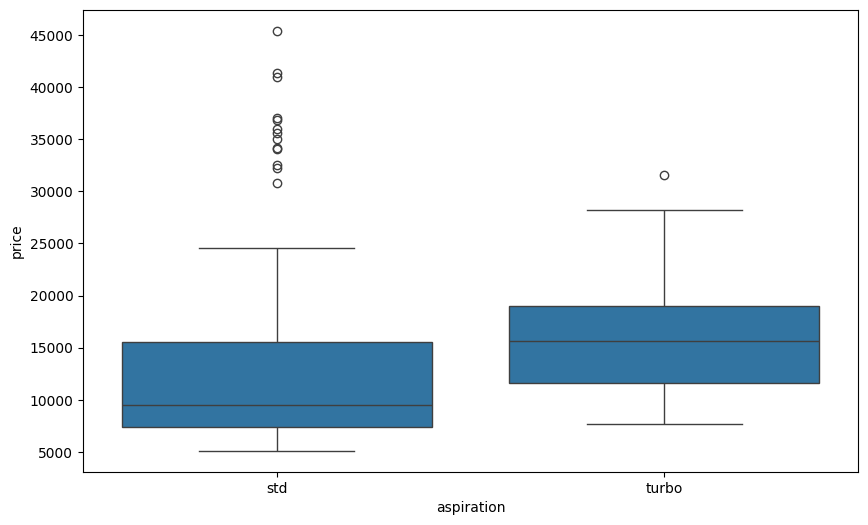

In [20]:
# boxplot to visually see if there is a significant difference on fuel type on price
plt.figure(figsize=(10, 6))
sns.boxplot(x='aspiration', y='price', data=df)
plt.show()

In [21]:
# Is there an association between aspiration and price
f_statistic, p_value = stats.f_oneway(df[df['aspiration'] == 'std']['price'], df[df['fuel-type'] == 'turbo']['price'])
print("F_statistic : {} | p_value: {}".format(f_statistic, p_value))

F_statistic : nan | p_value: nan


C:\Users\patel\AppData\Local\Temp\ipykernel_3512\4231574419.py:2: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  f_statistic, p_value = stats.f_oneway(df[df['aspiration'] == 'std']['price'], df[df['fuel-type'] == 'turbo']['price'])


In [22]:
# frequency values for catgorical variable - aspiration
df['aspiration'].value_counts()

aspiration
std      165
turbo     36
Name: count, dtype: int64

In [23]:
# We have imbalances categorical variable - aspiration
# visually speaking aspiration does have difference in the mean price

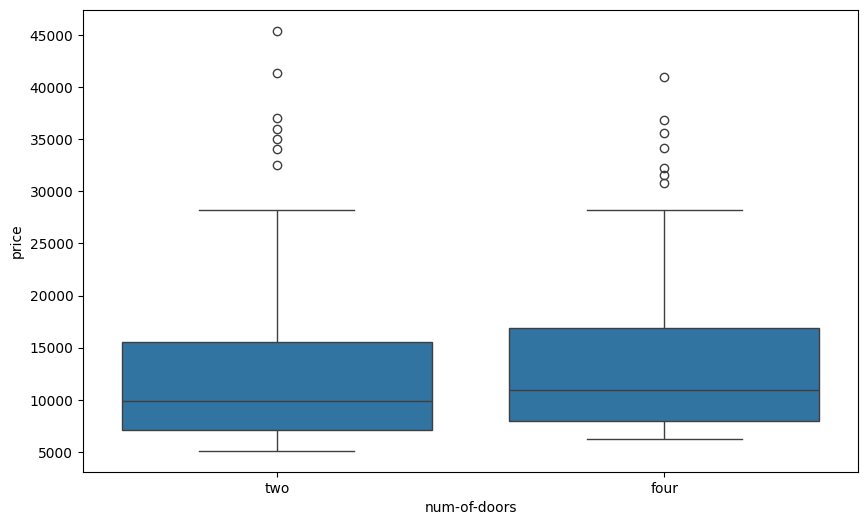

In [24]:
# boxplot to visually see if there is a significant difference on num-of-doors on price
plt.figure(figsize=(10, 6))
sns.boxplot(x='num-of-doors', y='price', data=df)
plt.show()

In [25]:
# Is there an association between aspiration and price
f_statistic, p_value = stats.f_oneway(df[df['num-of-doors'] == 'two']['price'], df[df['num-of-doors'] == 'four']['price'])
print("F_statistic : {} | p_value: {}".format(f_statistic, p_value))

F_statistic : 0.3589973711707057 | p_value: 0.5497450927348417


In [26]:
# there is hardly any impact of num-of-doors on the price

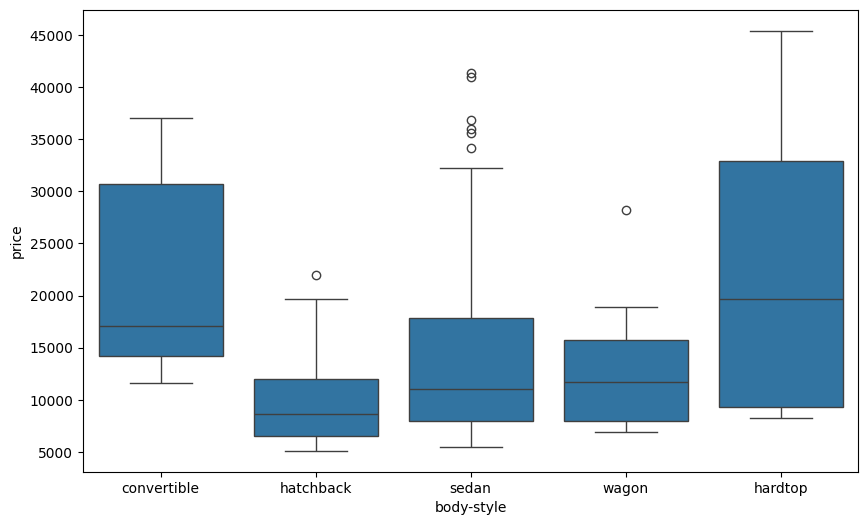

In [27]:
# boxplot to visually see if there is a significant difference on body-style on price
plt.figure(figsize=(10, 6))
sns.boxplot(x='body-style', y='price', data=df)
plt.show()

In [28]:
# Is there an association between body-style and price
f_statistic, p_value = stats.f_oneway(df[df['body-style'] == 'convertible']['price'], 
                                      df[df['body-style'] == 'hatchback']['price'],
                                      df[df['body-style'] == 'sedan']['price'],
                                      df[df['body-style'] == 'wagon']['price'],
                                      df[df['body-style'] == 'hardtop']['price']
                                     )
print("F_statistic : {} | p_value: {}".format(f_statistic, p_value))

F_statistic : 9.12875185470821 | p_value: 8.779795237614632e-07


In [29]:
# post hoc analysis
tukey_results = pairwise_tukeyhsd(endog=df['price'], groups=df['body-style'], alpha=0.05)
print("\nPost-Hoc Test (Tukey's HSD):")
print(tukey_results)


Post-Hoc Test (Tukey's HSD):
         Multiple Comparison of Means - Tukey HSD, FWER=0.05          
   group1     group2    meandiff  p-adj     lower      upper    reject
----------------------------------------------------------------------
convertible   hardtop       318.0    1.0 -10641.7206 11277.7206  False
convertible hatchback -11933.0588 0.0018 -20575.6081 -3290.5096   True
convertible     sedan  -7430.7447 0.1212 -15975.8326  1114.3432  False
convertible     wagon    -9518.54 0.0395 -18744.0695  -293.0105   True
    hardtop hatchback -12251.0588 0.0001 -19836.1959 -4665.9218   True
    hardtop     sedan  -7748.7447  0.038 -15222.6441  -274.8452   True
    hardtop     wagon    -9836.54 0.0105 -18079.7821 -1593.2979   True
  hatchback     sedan   4502.3141 0.0016   1271.6247  7733.0036   True
  hatchback     wagon   2414.5188  0.628   -2331.977  7161.0146  False
      sedan     wagon  -2087.7953 0.7167  -6654.4233  2478.8327  False
-----------------------------------------------

In [30]:
# body-style and price seem to have some association

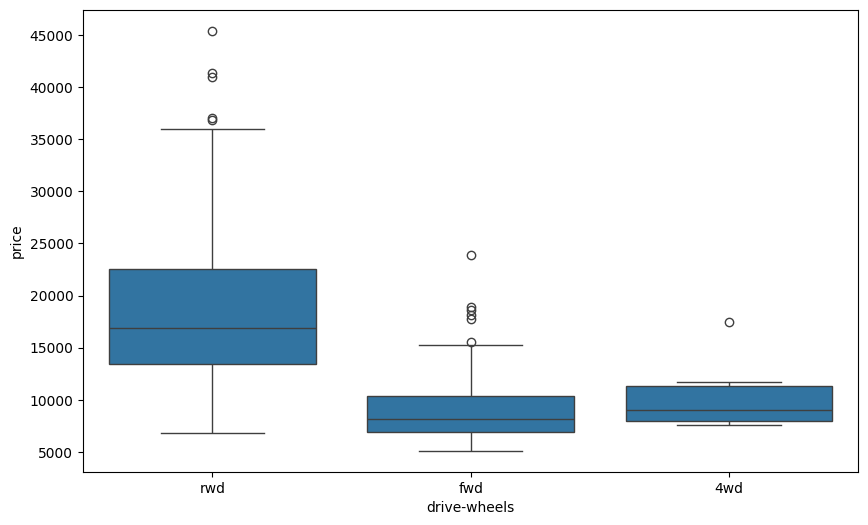

In [31]:
# boxplot to visually see if there is a significant difference on body-style on price
plt.figure(figsize=(10, 6))
sns.boxplot(x='drive-wheels', y='price', data=df)
plt.show()

In [32]:
# Is there an association between aspiration and price
f_statistic, p_value = stats.f_oneway(df[df['drive-wheels'] == 'rwd']['price'], 
                                      df[df['drive-wheels'] == 'fwd']['price'],
                                      df[df['drive-wheels'] == '4wd']['price']
                                      )
print("F_statistic : {} | p_value: {}".format(f_statistic, p_value))

F_statistic : 67.95406500780402 | p_value: 3.39454435771491e-23


In [33]:
# post hoc analysis
tukey_results = pairwise_tukeyhsd(endog=df['price'], groups=df['drive-wheels'], alpha=0.05)
print("\nPost-Hoc Test (Tukey's HSD):")
print(tukey_results)


Post-Hoc Test (Tukey's HSD):
    Multiple Comparison of Means - Tukey HSD, FWER=0.05     
group1 group2  meandiff  p-adj    lower      upper    reject
------------------------------------------------------------
   4wd    fwd  -996.2203 0.8974 -6302.5087   4310.068  False
   4wd    rwd  9516.6133 0.0001  4114.6082 14918.6184   True
   fwd    rwd 10512.8337    0.0  8367.9755 12657.6919   True
------------------------------------------------------------


In [34]:
# drive-wheels and price seem to have some association

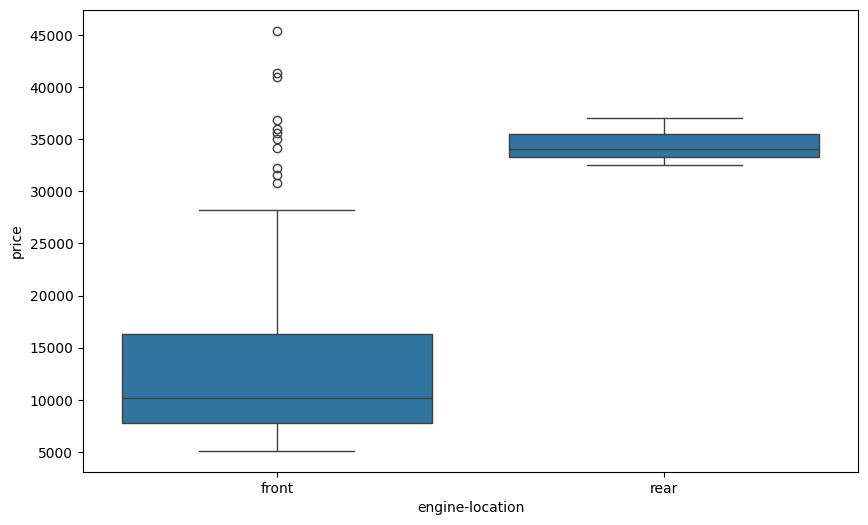

In [35]:
# boxplot to visually see if there is a significant difference on body-style on price
plt.figure(figsize=(10, 6))
sns.boxplot(x='engine-location', y='price', data=df)
plt.show()

In [36]:
# Is there an association between aspiration and price
f_statistic, p_value = stats.f_oneway(df[df['engine-location'] == 'front']['price'], 
                                      df[df['engine-location'] == 'rear']['price']
                                      )
print("F_statistic : {} | p_value: {}".format(f_statistic, p_value))

F_statistic : 24.495550318865693 | p_value: 1.5834900197776837e-06


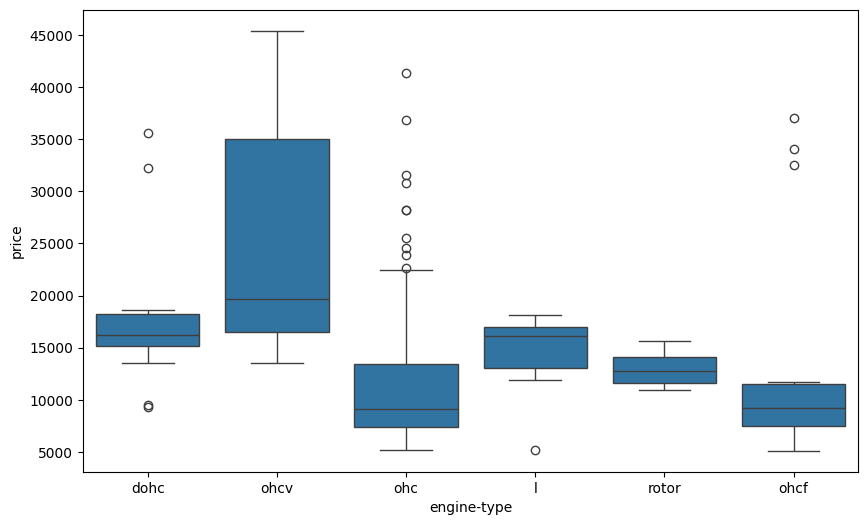

In [37]:
# boxplot to visually see if there is a significant difference on body-style on price
plt.figure(figsize=(10, 6))
sns.boxplot(x='engine-type', y='price', data=df)
plt.show()

In [38]:
# Is there an association between aspiration and price
f_statistic, p_value = stats.f_oneway(df[df['engine-type'] == 'dohc']['price'], 
                                      df[df['engine-type'] == 'ohcv']['price'],
                                      df[df['engine-type'] == 'ohc']['price'],
                                      df[df['engine-type'] == 'I']['price'],
                                      df[df['engine-type'] == 'rotor']['price'],
                                      df[df['engine-type'] == 'ohcf']['price']
                                      )
print("F_statistic : {} | p_value: {}".format(f_statistic, p_value))

F_statistic : nan | p_value: nan


C:\Users\patel\AppData\Local\Temp\ipykernel_3512\3030925277.py:2: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  f_statistic, p_value = stats.f_oneway(df[df['engine-type'] == 'dohc']['price'],


In [39]:
df['engine-type'].value_counts()

engine-type
ohc      145
ohcf      15
ohcv      13
dohc      12
l         12
rotor      4
Name: count, dtype: int64

In [40]:
# classify low frequency classes into other
def classify(row):
    if row['engine-type'] in ['ohc']:
        return row['engine-type']
    else:
        return 'other'
df['engine-type'] = df.apply(classify, axis=1)

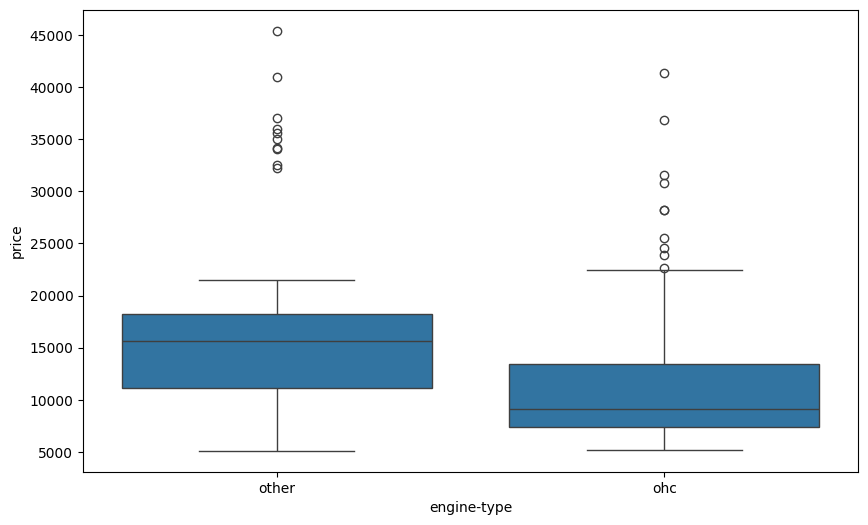

In [41]:
# boxplot to visually see if there is a significant difference on body-style on price
plt.figure(figsize=(10, 6))
sns.boxplot(x='engine-type', y='price', data=df)
plt.show()

In [42]:
# Is there an association between aspiration and price
f_statistic, p_value = stats.f_oneway(df[df['engine-type'] == 'ohc']['price'], 
                                      df[df['engine-type'] == 'other']['price']
                                      )
print("F_statistic : {} | p_value: {}".format(f_statistic, p_value))

F_statistic : 24.79402973387851 | p_value: 1.379690984885389e-06


In [43]:
# ohc has a good say in price than others

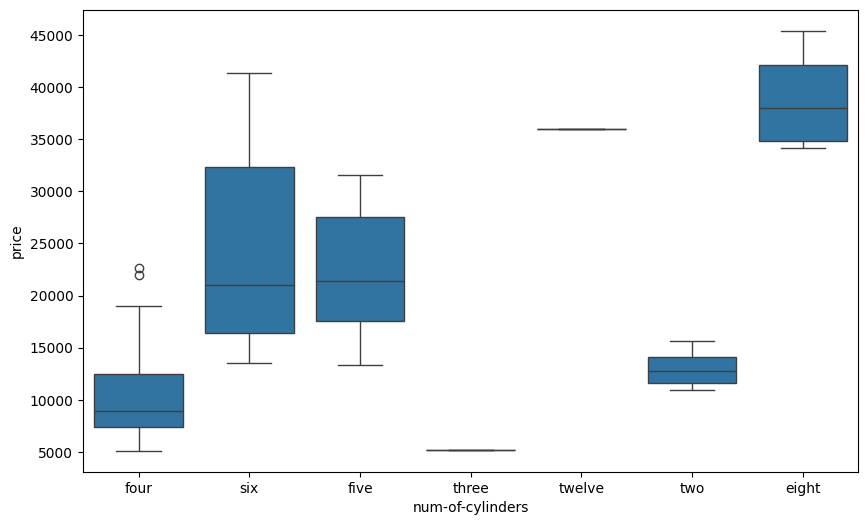

In [44]:
# assocaition of num-of-cylinders with price 
plt.figure(figsize=(10, 6))
sns.boxplot(x='num-of-cylinders', y='price', data=df)
plt.show()

In [45]:
# Is there an association between aspiration and price
f_statistic, p_value = stats.f_oneway(df[df['num-of-cylinders'] == 'four']['price'], 
                                      df[df['num-of-cylinders'] == 'six']['price'],
                                      df[df['num-of-cylinders'] == 'five']['price'],
                                      df[df['num-of-cylinders'] == 'three']['price'],
                                      df[df['num-of-cylinders'] == 'twelve']['price'],
                                      df[df['num-of-cylinders'] == 'two']['price'],
                                      df[df['num-of-cylinders'] == 'eight']['price']
                                      )
print("F_statistic : {} | p_value: {}".format(f_statistic, p_value))

F_statistic : 54.94365304663241 | p_value: 2.8701445428124772e-39


In [46]:
# post hoc analysis
tukey_results = pairwise_tukeyhsd(endog=df['price'], groups=df['num-of-cylinders'], alpha=0.05)

print("\nPost-Hoc Test (Tukey's HSD):")
print(tukey_results)


Post-Hoc Test (Tukey's HSD):
      Multiple Comparison of Means - Tukey HSD, FWER=0.05      
group1 group2   meandiff  p-adj     lower       upper    reject
---------------------------------------------------------------
 eight   five    -16892.4    0.0 -25549.6395  -8235.1605   True
 eight   four -28596.8025    0.0 -36006.1255 -21187.4796   True
 eight    six -15228.1667    0.0 -23131.1089  -7325.2244   True
 eight  three    -33749.0    0.0 -50109.6448 -17388.3552   True
 eight twelve     -2900.0 0.9984 -19260.6448  13460.6448  False
 eight    two    -25880.0    0.0 -36227.3803 -15532.6197   True
  five   four -11704.4025    0.0 -16476.9892  -6931.8159   True
  five    six   1664.2333 0.9722  -3843.5804   7172.0471  False
  five  three    -16856.6 0.0212 -32204.2452  -1508.9548   True
  five twelve     13992.4 0.0997  -1355.2452  29340.0452  False
  five    two     -8987.6 0.0362 -17644.8395   -330.3605   True
  four    six  13368.6359    0.0  10161.4122  16575.8596   True
  four  th

In [47]:
# there seems to be assocation between num-of-cylinders with price

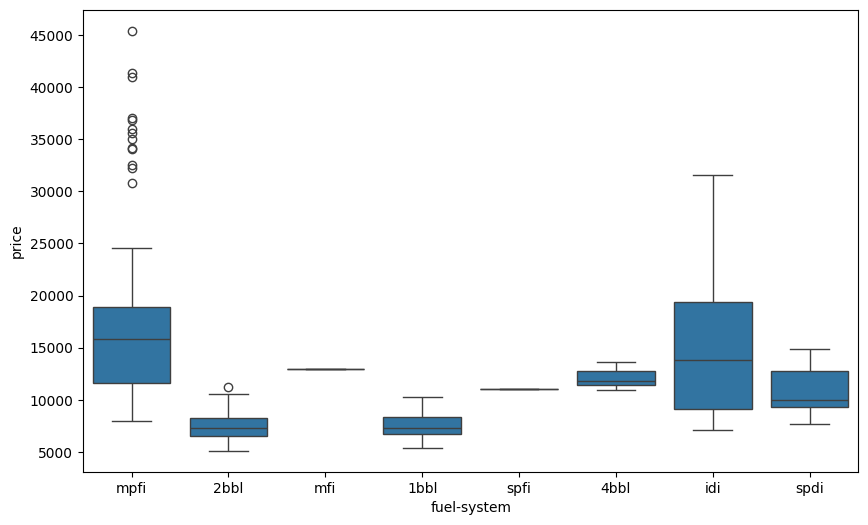

In [48]:
# assocaition of fuel-system with price 
plt.figure(figsize=(10, 6))
sns.boxplot(x='fuel-system', y='price', data=df)
plt.show()

In [49]:
# Is there an association between aspiration and price
f_statistic, p_value = stats.f_oneway(df[df['fuel-system'] == 'mpfi']['price'], 
                                      df[df['fuel-system'] == '2bbl']['price'],
                                      df[df['fuel-system'] == 'mfi']['price'],
                                      df[df['fuel-system'] == '1bbl']['price'],
                                      df[df['fuel-system'] == 'spfi']['price'],
                                      df[df['fuel-system'] == '4bbl']['price'],
                                      df[df['fuel-system'] == 'idi']['price'],
                                      df[df['fuel-system'] == 'spdi']['price']
                                      )
print("F_statistic : {} | p_value: {}".format(f_statistic, p_value))

F_statistic : 15.024444173557075 | p_value: 1.3142579909174896e-15


In [50]:
# post hoc analysis
tukey_results = pairwise_tukeyhsd(endog=df['price'], groups=df['fuel-system'], alpha=0.05)

print("\nPost-Hoc Test (Tukey's HSD):")
print(tukey_results)


Post-Hoc Test (Tukey's HSD):
     Multiple Comparison of Means - Tukey HSD, FWER=0.05     
group1 group2  meandiff  p-adj     lower      upper    reject
-------------------------------------------------------------
  1bbl   2bbl  -122.3423    1.0  -6632.4994  6387.8148  False
  1bbl   4bbl  4589.4545 0.9598  -8401.8934 17580.8025  False
  1bbl    idi  8282.6045 0.0188    795.4521  15769.757   True
  1bbl    mfi  5408.4545 0.9932 -15424.0482 26240.9573  False
  1bbl   mpfi 10049.5958 0.0001   3686.3966 16412.7951   True
  1bbl   spdi   3434.899 0.9384  -5529.9828 12399.7808  False
  1bbl   spfi  3492.4545 0.9996 -17340.0482 24324.9573  False
  2bbl   4bbl  4711.7969 0.9235  -7070.6083 16494.2021  False
  2bbl    idi  8404.9469    0.0   3295.4066 13514.4871   True
  2bbl    mfi  5530.7969 0.9903  -14570.027 25631.6208  False
  2bbl   mpfi 10171.9382    0.0   6925.3622 13418.5141   True
  2bbl   spdi  3557.2413 0.7874  -3543.3964 10657.8791  False
  2bbl   spfi  3614.7969 0.9993  -16486.

In [51]:
# post hoc analysis suggests very few classes within fuel system deciding the price

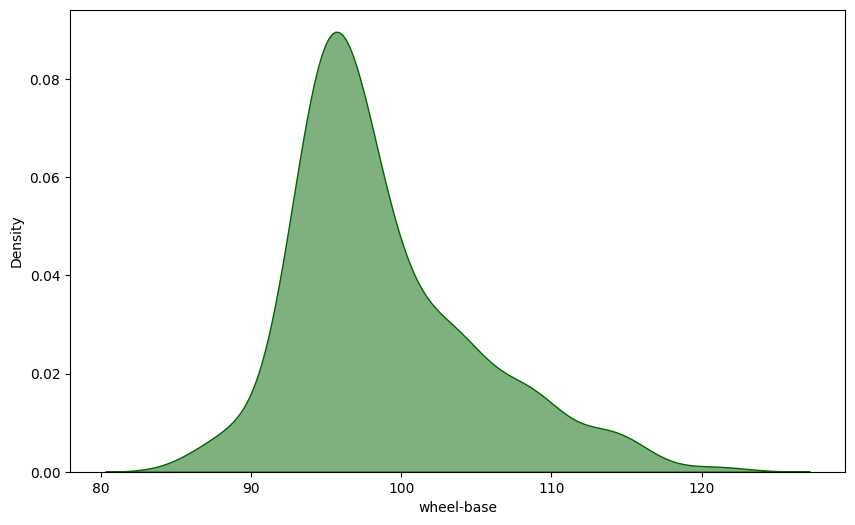

In [52]:
# continuous variables
# univariate analyses
plt.figure(figsize=(10, 6))
sns.kdeplot(df['wheel-base'], color='darkgreen', linewidth=1, fill=True, alpha=0.5)
plt.show()

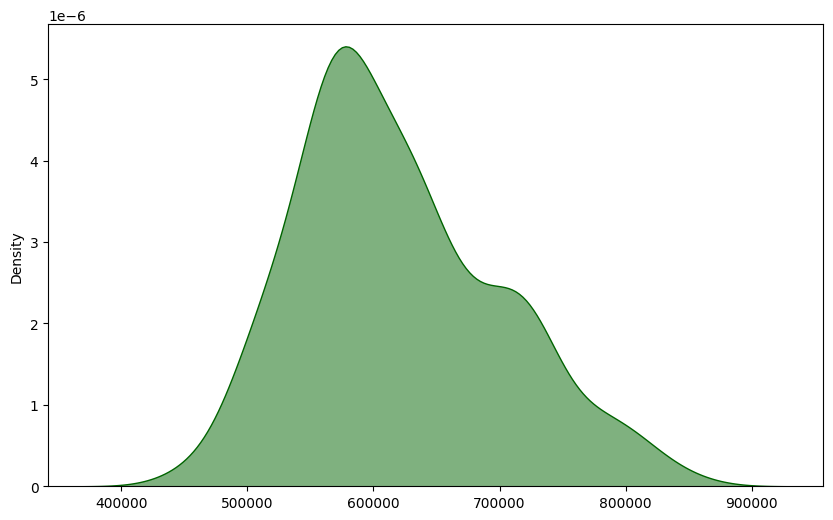

In [53]:
# length * width * height
plt.figure(figsize=(10, 6))
sns.kdeplot(df['length']*df['width']*df['height'], color='darkgreen', linewidth=1, fill=True, alpha=0.5)
plt.show()

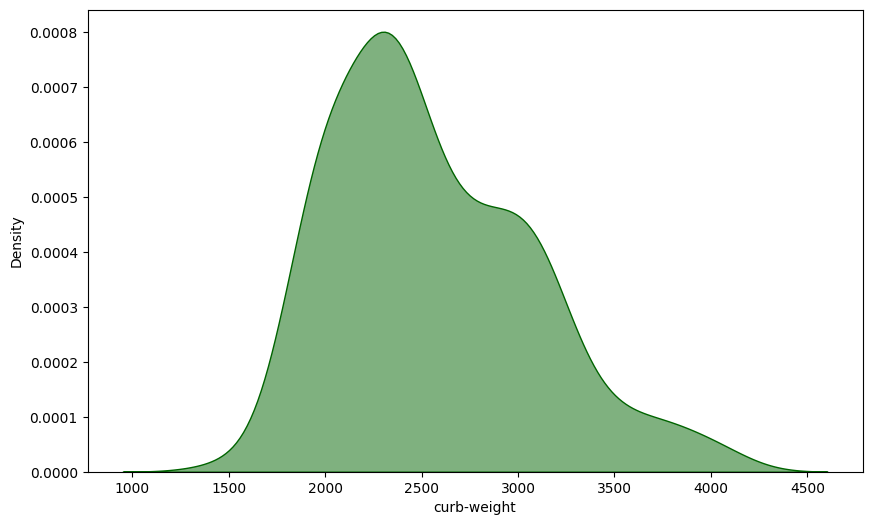

In [54]:
# curb-weight
plt.figure(figsize=(10, 6))
sns.kdeplot(df['curb-weight'], color='darkgreen', linewidth=1, fill=True, alpha=0.5)
plt.show()

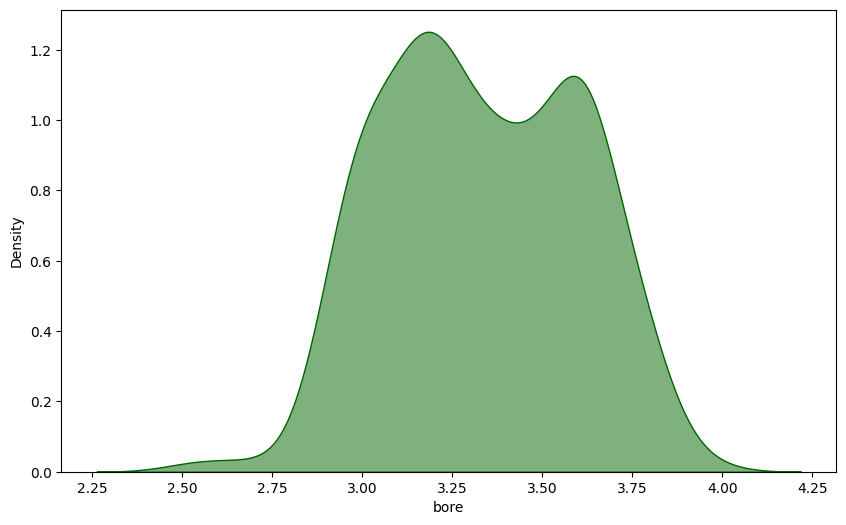

In [55]:
# bore, 
plt.figure(figsize=(10, 6))
sns.kdeplot(df['bore'], color='darkgreen', linewidth=1, fill=True, alpha=0.5)
plt.show()

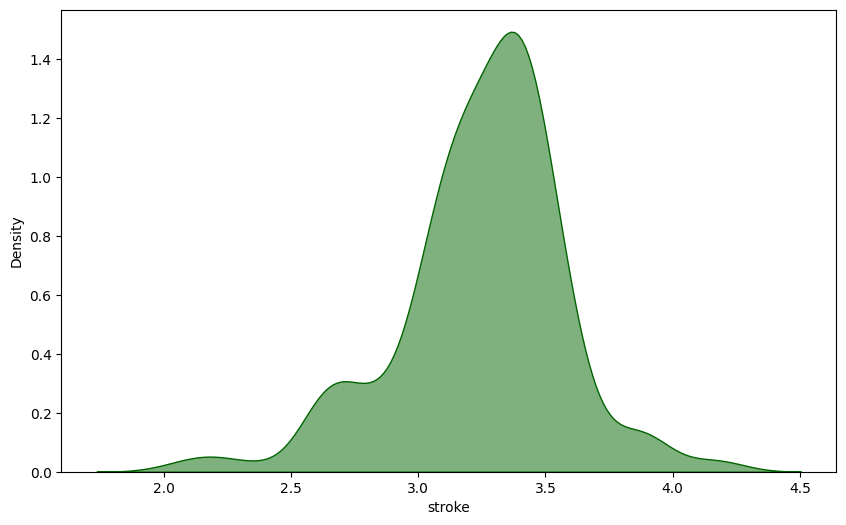

In [56]:
# stroke
plt.figure(figsize=(10, 6))
sns.kdeplot(df['stroke'], color='darkgreen', linewidth=1, fill=True, alpha=0.5)
plt.show()

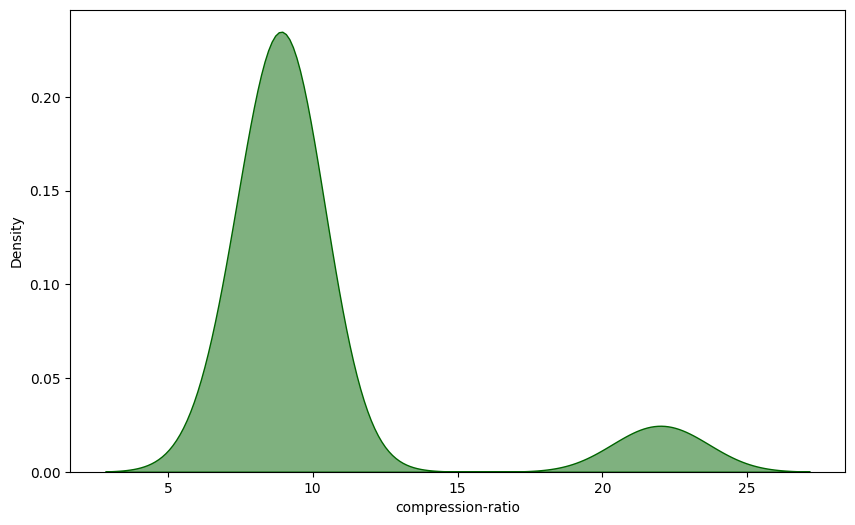

In [57]:
# compression-ratio
plt.figure(figsize=(10, 6))
sns.kdeplot(df['compression-ratio'], color='darkgreen', linewidth=1, fill=True, alpha=0.5)
plt.show()

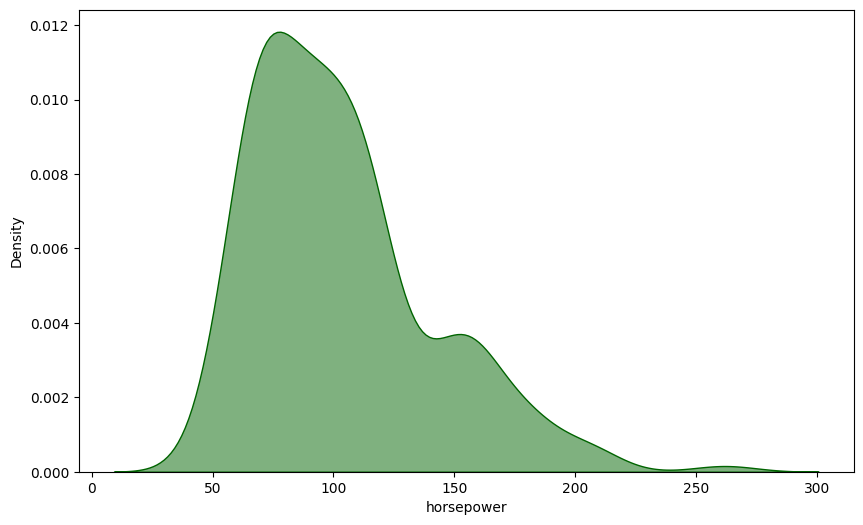

In [58]:
# horsepower
plt.figure(figsize=(10, 6))
sns.kdeplot(df['horsepower'], color='darkgreen', linewidth=1, fill=True, alpha=0.5)
plt.show()

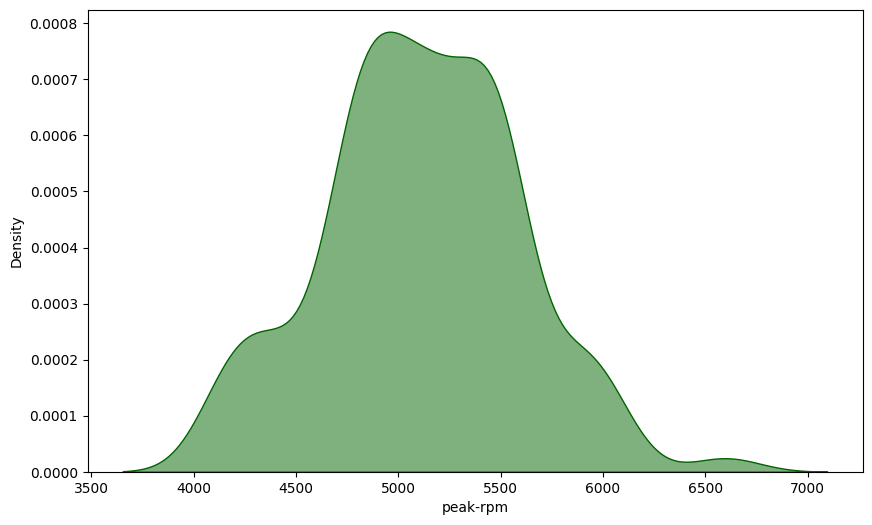

In [59]:
# peak-rpm
plt.figure(figsize=(10, 6))
sns.kdeplot(df['peak-rpm'], color='darkgreen', linewidth=1, fill=True, alpha=0.5)
plt.show()

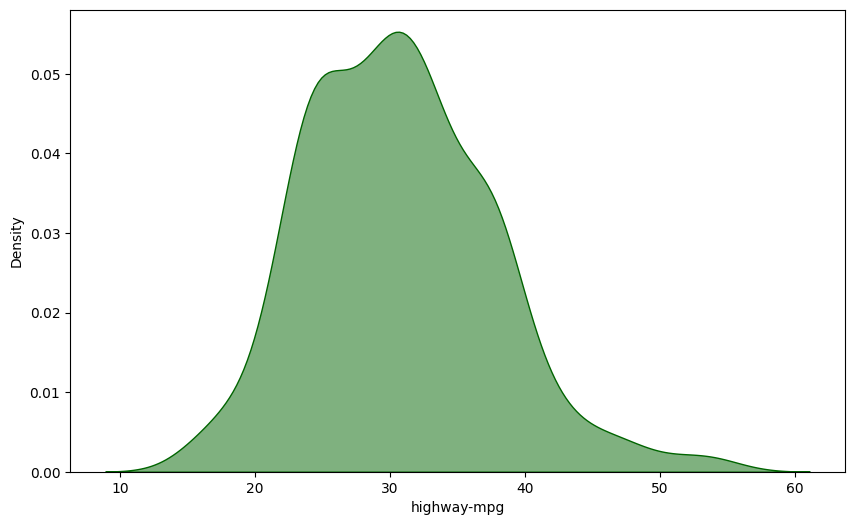

In [60]:
# highway-mpg
plt.figure(figsize=(10, 6))
sns.kdeplot(df['highway-mpg'], color='darkgreen', linewidth=1, fill=True, alpha=0.5)
plt.show()

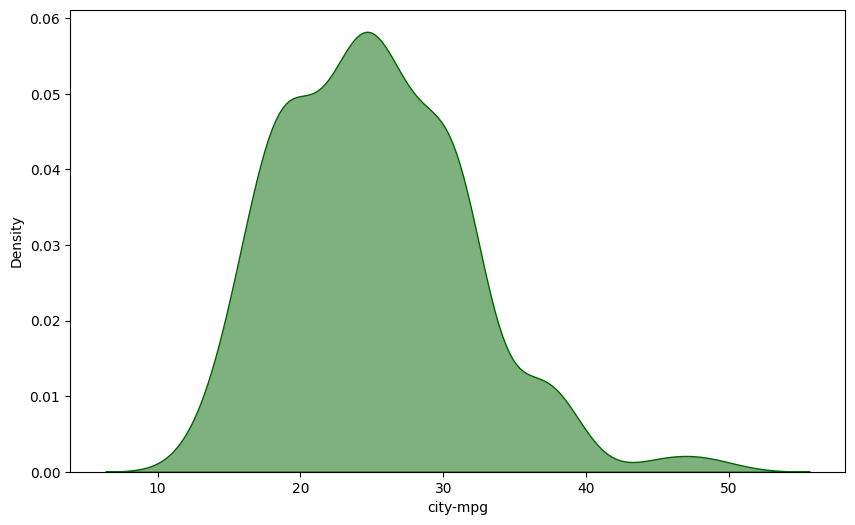

In [61]:
# city-mpg
plt.figure(figsize=(10, 6))
sns.kdeplot(df['city-mpg'], color='darkgreen', linewidth=1, fill=True, alpha=0.5)
plt.show()

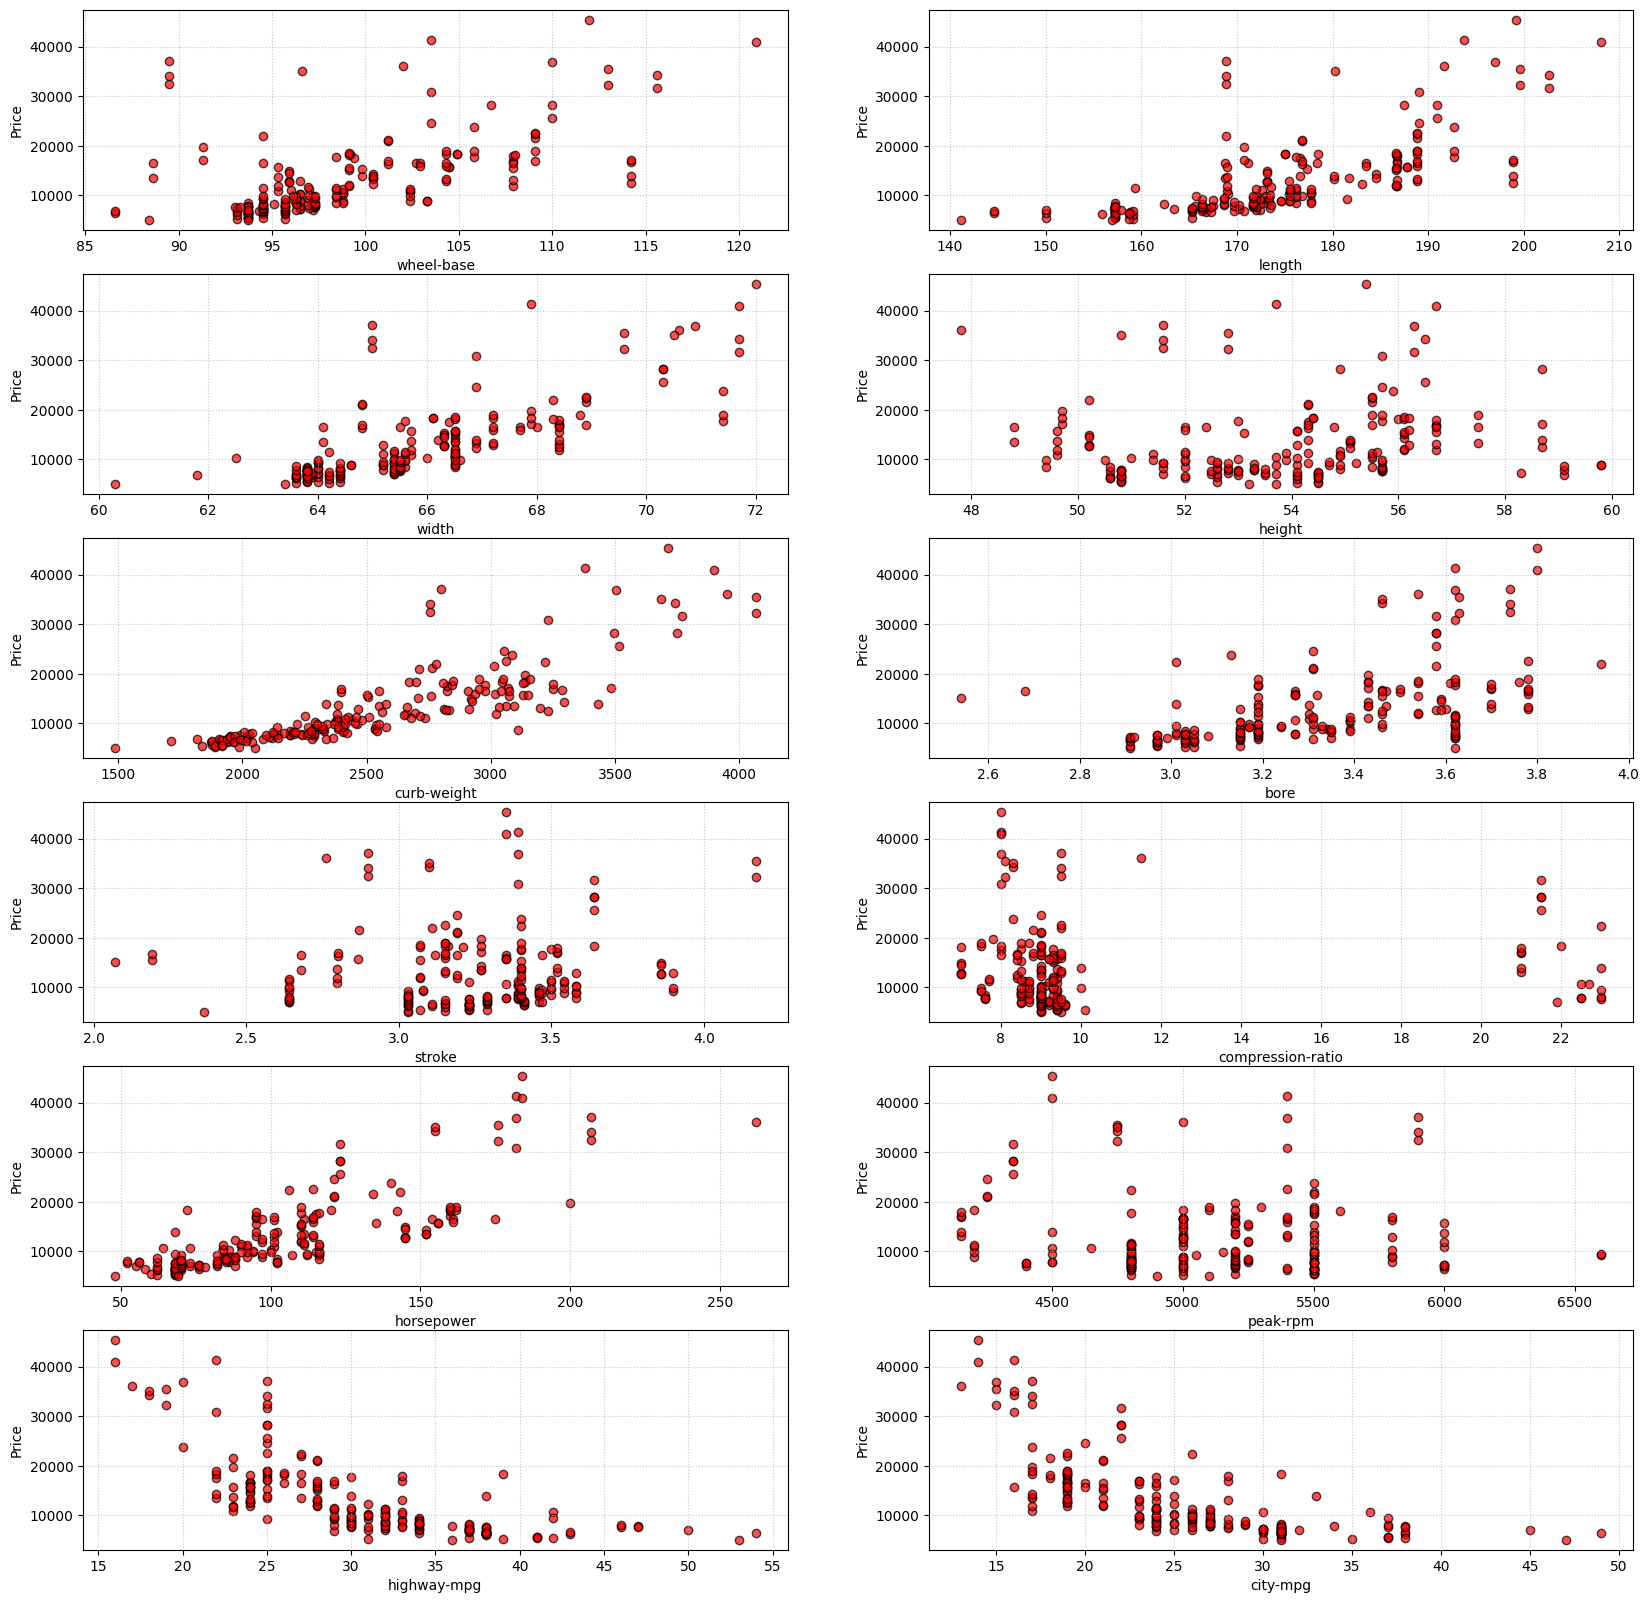

In [62]:
# 
fig, axes = plt.subplots(6, 2, figsize=(20, 20)) 

for index, item in enumerate(['wheel-base', 'length', 'width', 'height', 'curb-weight', 'bore', 'stroke', 'compression-ratio', 
                              'horsepower', 'peak-rpm', 'highway-mpg', 'city-mpg']):
    axes = axes.flatten()
    ax = axes[index]

    ax.scatter(
        df[item],
        df['price'],
        color='red',          
        marker='o',           
        alpha=0.7,            
        edgecolors='black'
    )
    
    ax.set_xlabel(item, fontsize=10)
    ax.set_ylabel('Price', fontsize=10)
    ax.grid(True, linestyle=':', alpha=0.7)
    
plt.show()

In [63]:
# We can see the relationship between variables and price.
# there could potentially be some multicollinear variables present

In [64]:
# vif - multicollinearity
X = df[['wheel-base', 'length', 'width', 'height', 'curb-weight', 'bore', 
        'stroke', 'compression-ratio', 'horsepower', 'peak-rpm', 'highway-mpg', 'city-mpg']]
X_with_const = add_constant(X)
vif_data = pd.DataFrame()
vif_data["feature"] = X_with_const.columns
vif_data["VIF"] = [variance_inflation_factor(X_with_const.values, i) for i in range(X_with_const.shape[1])]
vif_data

,feature,VIF
0,const,5057.603890
1,wheel-base,7.446513
2,length,9.653204
3,width,5.746498
4,height,2.134602
5,curb-weight,14.281756
6,bore,2.083646
7,stroke,1.171759
8,compression-ratio,2.089948
9,horsepower,6.001832


In [65]:
# we would resort to using LASSO as we see multicollinearity

In [66]:
df.columns

Index(['symboling', 'make', 'fuel-type', 'aspiration', 'num-of-doors',
       'body-style', 'drive-wheels', 'engine-location', 'wheel-base', 'length',
       'width', 'height', 'curb-weight', 'engine-type', 'num-of-cylinders',
       'engine-size', 'fuel-system', 'bore', 'stroke', 'compression-ratio',
       'horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg', 'price'],
      dtype='object')

In [67]:
# PREPROCESSING
categorical_features = ['make', 'fuel-type', 'aspiration', 
                        'body-style', 'num-of-doors', 'num-of-cylinders',
                        'body-style', 'drive-wheels', 'engine-location', 
                        'engine-type', 'fuel-system'
                       ]

continuous_features = ['wheel-base', 'length', 'width', 'height', 
                       'curb-weight', 'engine-size', 'bore', 
                       'stroke', 'compression-ratio', 'horsepower', 
                       'peak-rpm', 'city-mpg', 'highway-mpg'
                      ]
X = df[continuous_features + categorical_features]
y = df['price']

In [68]:
# one hot encoding for Lasso regression
X = pd.get_dummies(X, columns=categorical_features, drop_first=True)
feature_list_final = X.columns.tolist() 

In [69]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(f"Data split: Train size={X_train.shape[0]}, Test size={X_test.shape[0]}")

Data split: Train size=140, Test size=61


In [70]:
# scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [71]:
lasso_cv_model = LassoCV(
    alphas=100,       
    cv=5,              
    random_state=42,
    max_iter=10000     
)

lasso_cv_model.fit(X_train_scaled, y_train)

,eps,0.001
,n_alphas,'deprecated'
,alphas,100
,fit_intercept,True
,precompute,'auto'
,max_iter,10000
,tol,0.0001
,copy_X,True
,cv,5
,verbose,False
,n_jobs,None


In [72]:
optimal_alpha = lasso_cv_model.alpha_
optimal_alpha

np.float64(105.88915808094069)

<>:8: SyntaxWarning: invalid escape sequence '\l'
<>:10: SyntaxWarning: invalid escape sequence '\l'
<>:8: SyntaxWarning: invalid escape sequence '\l'
<>:10: SyntaxWarning: invalid escape sequence '\l'
C:\Users\patel\AppData\Local\Temp\ipykernel_3512\936840041.py:8: SyntaxWarning: invalid escape sequence '\l'
  plt.xlabel('Alpha ($\lambda$, Regularization Strength)')
C:\Users\patel\AppData\Local\Temp\ipykernel_3512\936840041.py:10: SyntaxWarning: invalid escape sequence '\l'
  plt.title('LassoCV: Cross-Validation Error vs. Alpha ($\lambda$)')


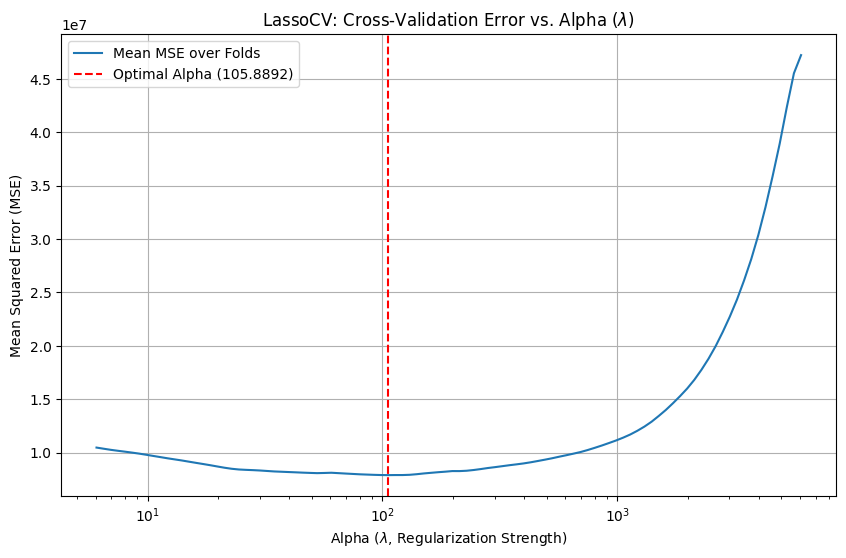

In [73]:
plt.figure(figsize=(10, 6))
alphas = lasso_cv_model.alphas_
mse_mean = np.mean(lasso_cv_model.mse_path_, axis=1)

plt.plot(alphas, mse_mean, label='Mean MSE over Folds')
plt.axvline(optimal_alpha, color='red', linestyle='--', label=f'Optimal Alpha ({optimal_alpha:.4f})')
plt.xscale('log')
plt.xlabel('Alpha ($\lambda$, Regularization Strength)')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('LassoCV: Cross-Validation Error vs. Alpha ($\lambda$)')
plt.legend()
plt.grid(True)
plt.show()

<>:10: SyntaxWarning: invalid escape sequence '\l'
<>:10: SyntaxWarning: invalid escape sequence '\l'
C:\Users\patel\AppData\Local\Temp\ipykernel_3512\2799148604.py:10: SyntaxWarning: invalid escape sequence '\l'
  plt.xlabel('Alpha ($\lambda$)')


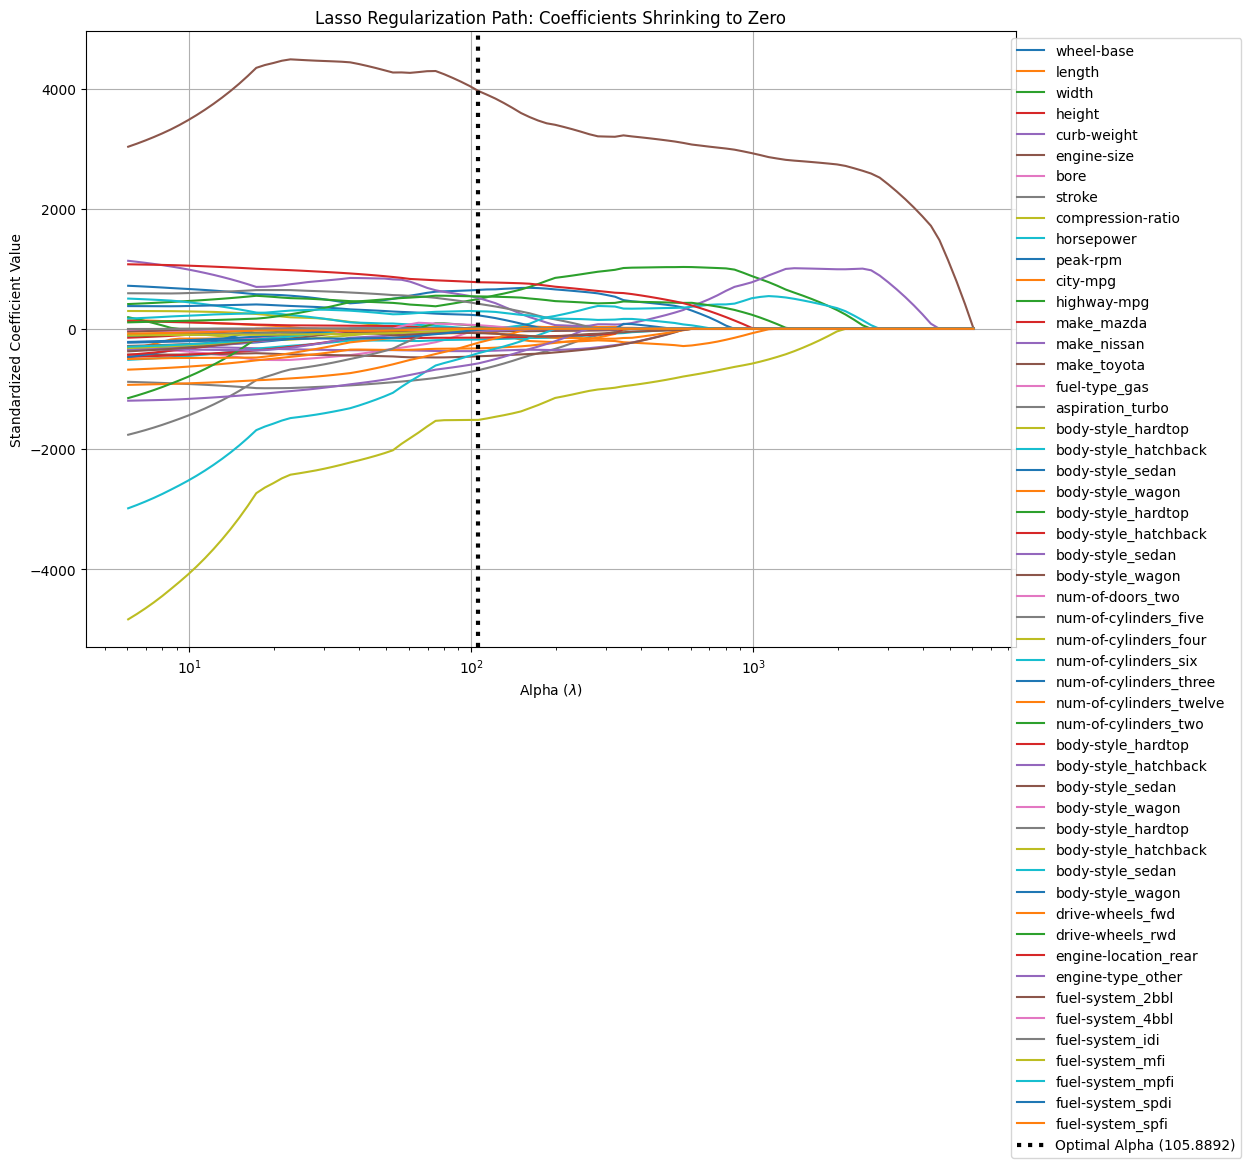

In [74]:
alphas_lasso, coefs_lasso, _ = lasso_path(X_train_scaled, y_train, alphas=lasso_cv_model.alphas_)

plt.figure(figsize=(12, 8))
for i, feature in enumerate(feature_list_final):
    plt.plot(alphas_lasso, coefs_lasso[i], label=feature)

plt.axvline(optimal_alpha, color='black', linestyle=':', linewidth=3, label=f'Optimal Alpha ({optimal_alpha:.4f})')

plt.xscale('log')
plt.xlabel('Alpha ($\lambda$)')
plt.ylabel('Standardized Coefficient Value')
plt.title('Lasso Regularization Path: Coefficients Shrinking to Zero')
plt.legend(loc='upper right', bbox_to_anchor=(1.25, 1))
plt.grid(True)
plt.show()

In [75]:
y_pred = lasso_cv_model.predict(X_test_scaled)

rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"\n--- Model Evaluation (Optimal Lambda/Alpha={optimal_alpha:.4f}) ---")
print(f"Mean Squared Error (MSE): {rmse:,.2f}")
print(f"R-squared Score (R²): {r2:.4f}")


--- Model Evaluation (Optimal Lambda/Alpha=105.8892) ---
Mean Squared Error (MSE): 3,372.39
R-squared Score (R²): 0.8800


In [76]:
# lets see what features were forced to zero for model interpretability
coef_df = pd.DataFrame({
    'Feature': feature_list_final,
    'Coefficient': lasso_cv_model.coef_.round(2)
})
# Sort by absolute coefficient value
coef_df['Abs_Coeff'] = coef_df['Coefficient'].abs()
coef_df = coef_df.sort_values(by='Abs_Coeff', ascending=True).drop(columns=['Abs_Coeff'])

In [77]:
coef_df

,Feature,Coefficient
3,height,0.00
13,make_mazda,0.00
9,horsepower,0.00
8,compression-ratio,0.00
12,highway-mpg,-0.00
22,body-style_hardtop,0.00
27,num-of-cylinders_five,-0.00
30,num-of-cylinders_three,0.00
24,body-style_sedan,0.00
25,body-style_wagon,-0.00


In [85]:
# fitting a MLR model and compare the performance with lasso 
model = LinearRegression(n_jobs=-1)
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

In [86]:
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(rmse)
print(r2)

3346.0986630997345
0.8818843717705471


In [87]:
# seems like the MLR model is at par with Lasso Model